# Data period features

This notebook characterizes operational and environmental features for each water quality data period.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly
from bayesian_wq_calibration.simulation import model_simulation
from bayesian_wq_calibration.plotting import plot_network
from bayesian_wq_calibration.constants import TIMESERIES_DIR
from bayesian_wq_calibration.data import get_sensor_stats, count_pressure_events, count_turbidity_events

Load sensing data for selected data period.

In [37]:
data_period = 19 # 19 calibration events (as at 30 September 2024)

try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)

    print(f"Data period: {data_period}")
    print(f"Start datetime: {flow_df['datetime'].unique()[0]}")
    print(f"End datetime: {flow_df['datetime'].unique()[-1]}")
except:
    print(f"Data period {data_period} does not exist.")

Data period: 19
Start datetime: 2024-09-18 00:00:00
End datetime: 2024-09-25 23:45:00


### Sensor map

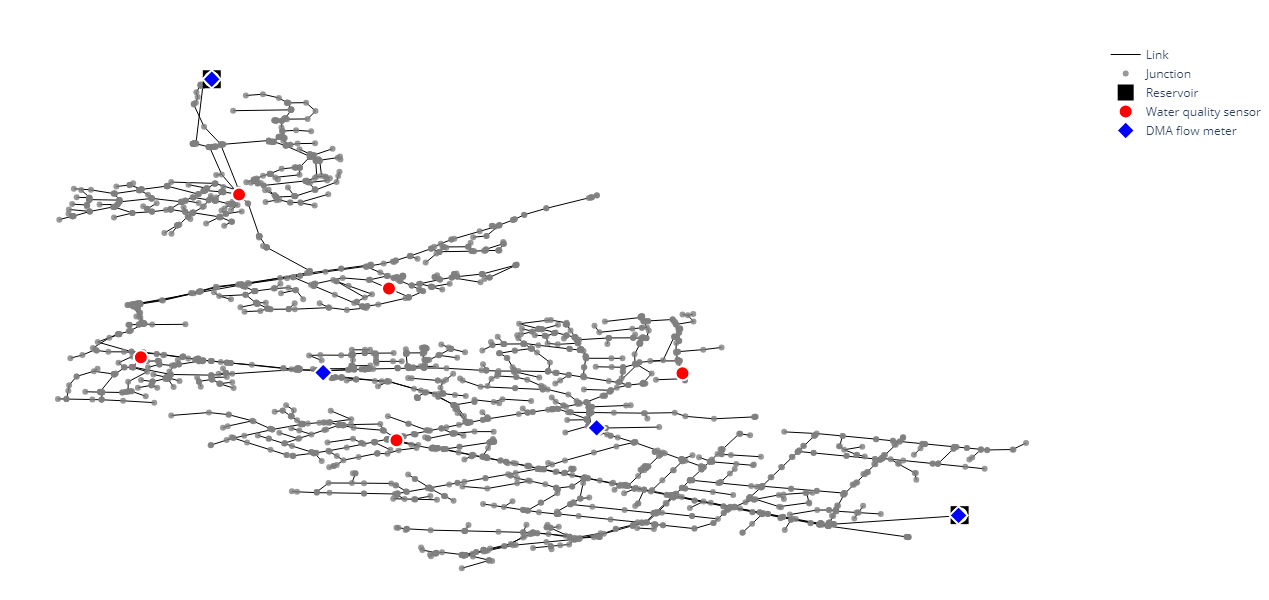

In [38]:
plot_network()

### Time series plotting
Chlorine data.

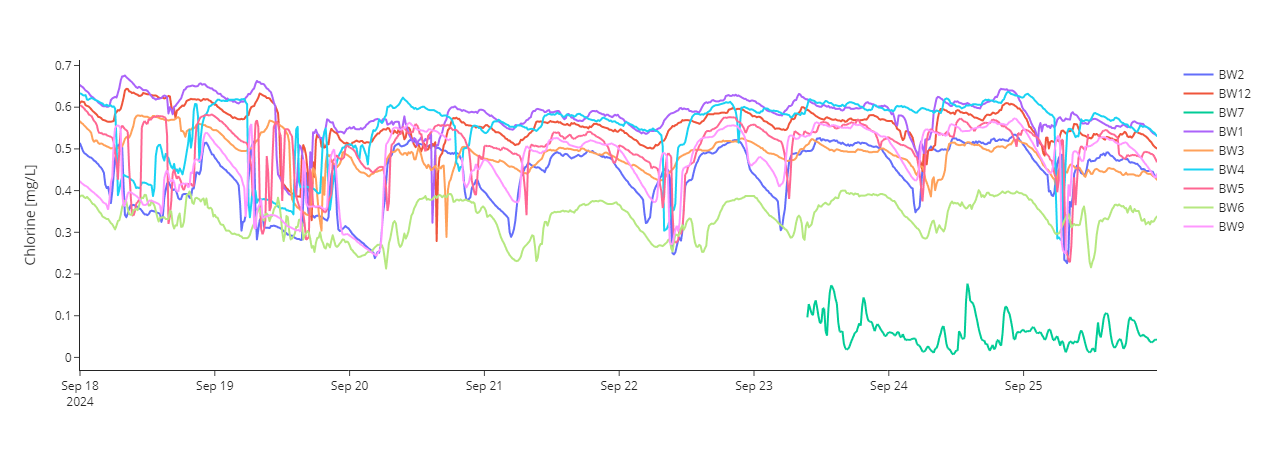

In [41]:
try:
    wq_bwfl_ids = wq_df['bwfl_id'].unique()
    plot_wq_df = wq_df[(wq_df['data_type'] == 'chlorine')]
    fig = px.line(
        plot_wq_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )
    fig.update_layout(
        xaxis_title='',
        yaxis_title='Chlorine [mg/L]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

Missing data summary.

In [42]:
summary_df = (plot_wq_df.groupby('bwfl_id')['mean'].agg(data_percentage=lambda x: int(x.notna().sum() / len(x) * 100)))
display(summary_df)

,data_percentage
bwfl_id,
BW1,100
BW12,100
BW2,100
BW3,100
BW4,100
BW5,99
BW6,100
BW7,32
BW9,99


Flow data.

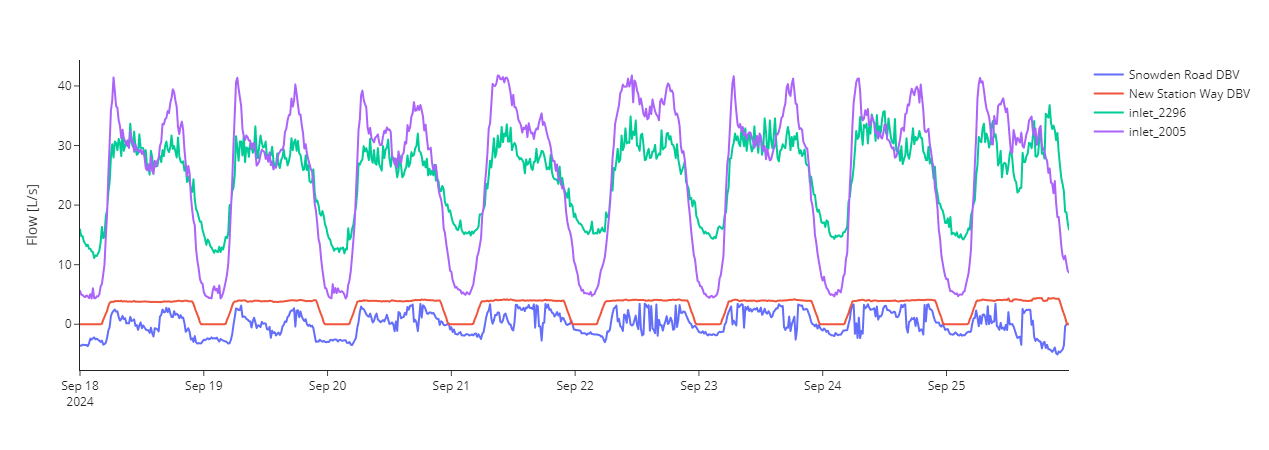

In [43]:
try:
    flow_bwfl_ids = ['inlet_2296', 'inlet_2005', 'Snowden Road DBV', 'New Station Way DBV']
    plot_flow_df = flow_df[flow_df['bwfl_id'].isin(flow_bwfl_ids)]
    fig = px.line(
        plot_flow_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )
    fig.update_layout(
        xaxis_title='',
        yaxis_title='Flow [L/s]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

### Hydraulic conditions

Flow comparison of data period v. entire dataset (2021-2024).  

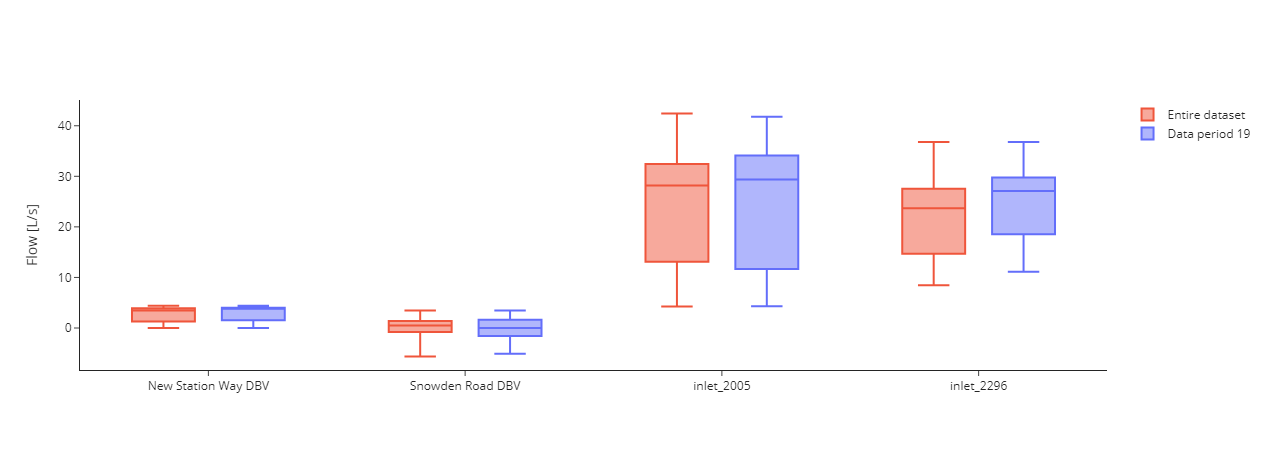

In [44]:
plot_flow_df = plot_flow_df.dropna(subset=['mean'])
flow_period_stats = plot_flow_df.groupby('bwfl_id')['mean'].describe(percentiles=[.01, .10, .25, .50, .75, .90, .99])
flow_dataset_stats = get_sensor_stats('flow', flow_bwfl_ids)

fig = go.Figure()

for i, bwfl_id in enumerate(flow_period_stats.index):
    stats = flow_dataset_stats.loc[bwfl_id]
    
    fig.add_trace(go.Box(
        x=[bwfl_id],
        lowerfence=[stats['min']],
        q1=[stats['25%']],
        median=[stats['50%']],
        q3=[stats['75%']],
        upperfence=[stats['max']],
        name='Entire dataset',
        marker_color=default_colors[1],
        boxpoints=False,
        offsetgroup='flow_dataset_stats',
        showlegend=(i == 0)
    ))

for i, bwfl_id in enumerate(flow_period_stats.index):
    stats = flow_period_stats.loc[bwfl_id]
    
    fig.add_trace(go.Box(
        x=[bwfl_id],
        lowerfence=[stats['min']],
        q1=[stats['25%']],
        median=[stats['50%']],
        q3=[stats['75%']],
        upperfence=[stats['max']],
        name=f'Data period {str(data_period).zfill(2)}',
        marker_color=default_colors[0],
        boxpoints=False,
        offsetgroup='flow_period_stats',
        showlegend=(i == 0)
    ))

fig.update_layout(
    yaxis_title='Flow [L/s]',
    xaxis_title='',
    xaxis=dict(
        tickmode='array',
        tickvals=flow_period_stats.index,
        ticktext=flow_period_stats.index
    ),
    legend_title_text='',
    template='simple_white',
    boxmode='group',
    height=450,
)

fig.show()

Count pressure events, defined as a change in pressure of over $\Delta p=$ {threshold} m during a 15-minute time step.

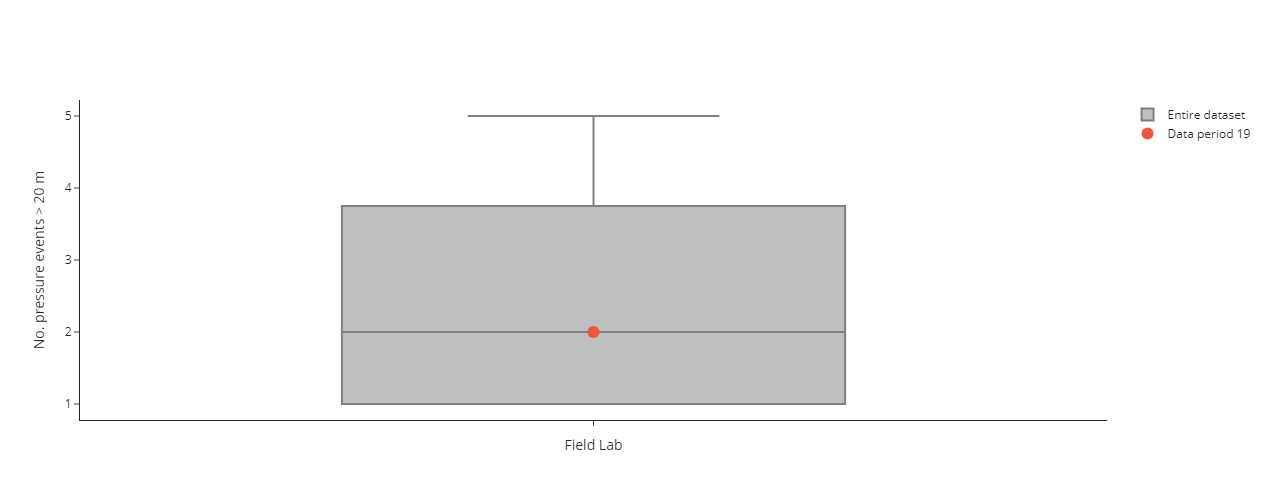

In [45]:
p_threshold = 20
pressure_events = count_pressure_events(threshold=p_threshold)

fig = go.Figure()

fig.add_trace(go.Box(
    y=pressure_events,
    x=['num_events'] * len(pressure_events),
    name='Entire dataset',
    marker_color='grey',
    boxpoints=False
))

fig.add_trace(go.Scatter(
    y=[pressure_events[data_period-1]],
    x=['num_events'],
    marker_color=default_colors[1],
    marker=dict(color=default_colors[1], size=12),
    mode="markers",
    name=f'Data period {str(data_period).zfill(2)}',
))

fig.update_layout(
    yaxis_title=f"No. pressure events > {p_threshold} m",
    xaxis_title='Field Lab',
    template='simple_white',
    height=500,
    width=500,
    xaxis=dict(
        showticklabels=False
    ),
    yaxis=dict(
        range=[0, None],
        tickformat=',d',
        nticks=6
    )
)

fig.show()

### Water quality conditions

Temperature comparison between data period and entire dataset (2021-2024).

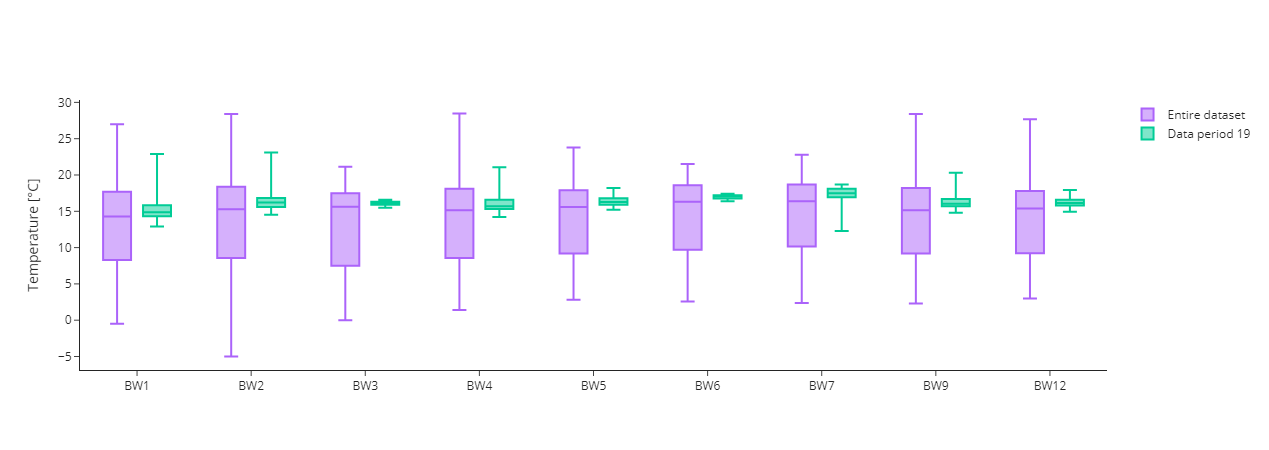

In [46]:
temp_df = wq_df[(wq_df['data_type'] == 'temperature')].dropna(subset=['mean'])
temp_period_stats = temp_df.groupby('bwfl_id')['mean'].describe(percentiles=[.01, .10, .25, .50, .75, .90, .99])
temp_dataset_stats = get_sensor_stats('temperature', temp_df['bwfl_id'].unique())

fig = go.Figure()

for i, bwfl_id in enumerate(temp_dataset_stats.index):
    stats = temp_dataset_stats.loc[bwfl_id]

    if stats['count'] != 0:
        fig.add_trace(go.Box(
            x=[bwfl_id],
            lowerfence=[stats['min']],
            q1=[stats['25%']],
            median=[stats['50%']],
            q3=[stats['75%']],
            upperfence=[stats['max']],
            name='Entire dataset',
            marker_color=default_colors[3],
            boxpoints=False,
            offsetgroup='temp_dataset_stats',
            showlegend=(i == 0)
        ))

for i, bwfl_id in enumerate(temp_period_stats.index):
    stats = temp_period_stats.loc[bwfl_id]

    if stats['count'] != 0:
        fig.add_trace(go.Box(
            x=[bwfl_id],
            lowerfence=[stats['min']],
            q1=[stats['25%']],
            median=[stats['50%']],
            q3=[stats['75%']],
            upperfence=[stats['max']],
            name=f'Data period {str(data_period).zfill(2)}',
            marker_color=default_colors[2],
            boxpoints=False,
            offsetgroup='temp_period_stats',
            showlegend=(i == 0)
        ))

fig.update_layout(
    yaxis_title='Temperature [\u00B0C]',
    xaxis_title='',
    xaxis=dict(
        tickmode='array',
        tickvals=sorted(temp_df['bwfl_id'].unique(), key=lambda x: int(x[2:])),
        ticktext=sorted(temp_df['bwfl_id'].unique(), key=lambda x: int(x[2:])),
        categoryorder='array',
        categoryarray=sorted(temp_df['bwfl_id'].unique(), key=lambda x: int(x[2:]))
    ),
    legend_title_text='',
    template='simple_white',
    boxmode='group',
    height=450,
)

fig.show()

pH comparison between data period and entire dataset (2021-2024).

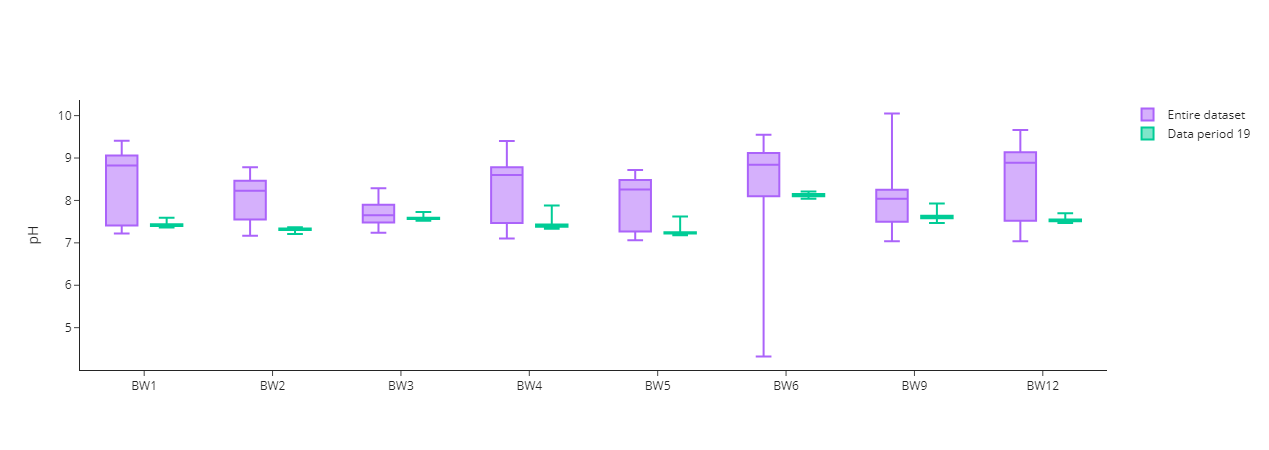

In [47]:
ph_df = wq_df[(wq_df['data_type'] == 'ph')].dropna(subset=['mean'])
ph_df.loc[(ph_df['mean'] < 4) | (ph_df['mean'] > 11), 'mean'] = np.nan
ph_period_stats = ph_df.groupby('bwfl_id')['mean'].describe(percentiles=[.01, .10, .25, .50, .75, .90, .99])
ph_dataset_stats = get_sensor_stats('ph', ph_df['bwfl_id'].unique())

fig = go.Figure()

for i, bwfl_id in enumerate(ph_dataset_stats.index):
    stats = ph_dataset_stats.loc[bwfl_id]

    if stats['count'] != 0:
        fig.add_trace(go.Box(
            x=[bwfl_id],
            lowerfence=[stats['min']],
            q1=[stats['25%']],
            median=[stats['50%']],
            q3=[stats['75%']],
            upperfence=[stats['max']],
            name='Entire dataset',
            marker_color=default_colors[3],
            boxpoints=False,
            offsetgroup='temp_dataset_stats',
            showlegend=(i == 0)
        ))

for i, bwfl_id in enumerate(ph_period_stats.index):
    stats = ph_period_stats.loc[bwfl_id]

    if stats['count'] != 0:
        fig.add_trace(go.Box(
            x=[bwfl_id],
            lowerfence=[stats['min']],
            q1=[stats['25%']],
            median=[stats['50%']],
            q3=[stats['75%']],
            upperfence=[stats['max']],
            name=f'Data period {str(data_period).zfill(2)}',
            marker_color=default_colors[2],
            boxpoints=False,
            offsetgroup='temp_period_stats',
            showlegend=(i == 0)
        ))

fig.update_layout(
    yaxis_title='pH',
    xaxis_title='',
    xaxis=dict(
        tickmode='array',
        tickvals=sorted(ph_df['bwfl_id'].unique(), key=lambda x: int(x[2:])),
        ticktext=sorted(ph_df['bwfl_id'].unique(), key=lambda x: int(x[2:])),
        categoryorder='array',
        categoryarray=sorted(ph_df['bwfl_id'].unique(), key=lambda x: int(x[2:]))
    ),
    legend_title_text='',
    template='simple_white',
    boxmode='group',
    height=450,
)

fig.show()

Count turbidity events, defined as a 15-minute timestep with turbidity value measurements above {ntu_threshold} NTU. 

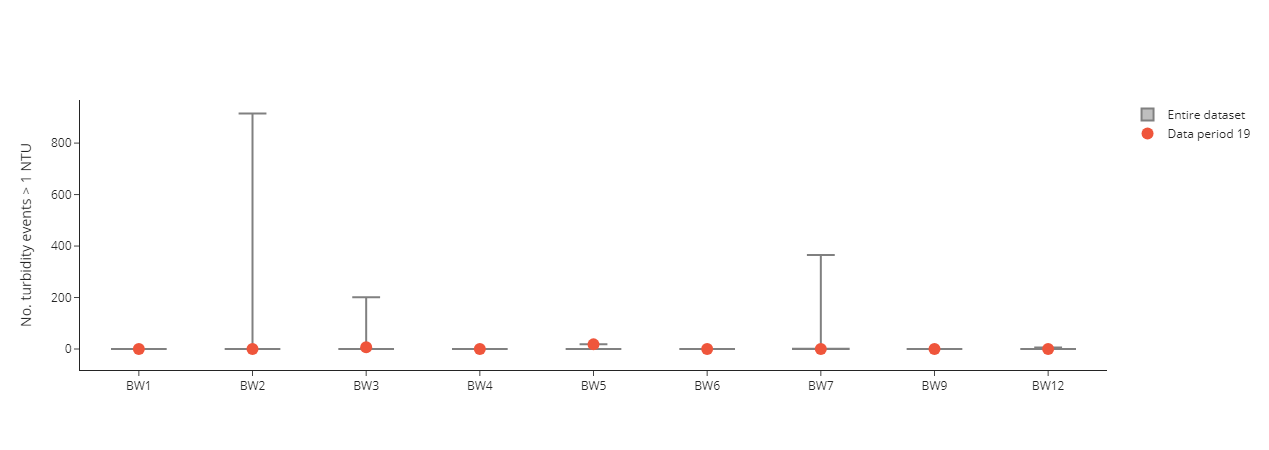

In [50]:
ntu_threshold = 1
turbidity_events = count_turbidity_events(threshold=ntu_threshold)
ntu_dataset_stats = turbidity_events.groupby('bwfl_id')['num_events'].describe(percentiles=[.01, .10, .25, .50, .75, .90, .99])
ntu_period_stats = turbidity_events[turbidity_events['data_period'] == data_period][['bwfl_id', 'num_events']]

fig = go.Figure()

for i, bwfl_id in enumerate(ntu_dataset_stats.index):
    stats = ntu_dataset_stats.loc[bwfl_id]

    if stats['count'] != 0:
        fig.add_trace(go.Box(
            x=[bwfl_id],
            lowerfence=[stats['min']],
            q1=[stats['25%']],
            median=[stats['50%']],
            q3=[stats['75%']],
            upperfence=[stats['max']],
            name='Entire dataset',
            marker_color='grey',
            boxpoints=False,
            offsetgroup='dataset_stats',
            showlegend=(i == 0)
        ))

fig.add_trace(go.Scatter(
    y=ntu_period_stats['num_events'],
    x=ntu_period_stats['bwfl_id'],
    marker_color=default_colors[1],
    marker=dict(color=default_colors[1], size=12),
    mode="markers",
    name=f'Data period {str(data_period).zfill(2)}',
))

fig.update_layout(
    yaxis_title=f"No. turbidity events > {ntu_threshold} NTU",
    xaxis_title='',
    xaxis=dict(
        tickmode='array',
        tickvals=sorted(turbidity_events['bwfl_id'].unique(), key=lambda x: int(x[2:])),
        ticktext=sorted(turbidity_events['bwfl_id'].unique(), key=lambda x: int(x[2:])),
        categoryorder='array',
        categoryarray=sorted(turbidity_events['bwfl_id'].unique(), key=lambda x: int(x[2:]))
    ),
    legend_title_text='',
    template='simple_white',
    boxmode='group',
    height=450,
)

fig.show()